### Initialize data

In [1]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*') # Silence RDKit warnings

import pandas as pd
df = pd.read_excel('dataset.xlsx')
df[['Ligand Name','SMILES', 'Ni conc [mM]', 'Sample ID', 'max h2 (umol)']]

,Ligand Name,SMILES,Ni conc [mM],Sample ID,max h2 (umol)
0,"1,2-Benzenedithiol",[S-]c1ccccc1[S-],0.025,L10,0.281460
1,triphenylphosphine,c1ccc(cc1)P(c2ccccc2)c3ccccc3,0.025,L11,0.058493
2,"1,2-bis(dicyclohexylphosphino)ethane",C1CCC(CC1)P(CCP(C2CCCCC2)C3CCCCC3)C4CCCCC4,0.025,L12,0.390512
3,2-Mercaptonicotinic acid,[O-]C(=O)c1cccnc1[S-],0.025,L2,4.068596
4,3-Aminopyridine-2(1H)-thione,C1=CNC(=S)C(=C1)N,0.025,L3,9.021096
...,...,...,...,...,...
499,"4,5-dichloro-o-phenylenediamine",Nc1cc(Cl)c(Cl)cc1N,0.700,L53,0.157703
500,"N,N'-diphenyl-p-phenylenediamine",N(c1ccccc1)c2ccc(Nc3ccccc3)cc2,0.700,L54,0.011934
501,3-mercaptopropionic acid,OC(=O)CCS,0.700,L55,11.290852
502,"3,3,3 triphenyl propionic acid",OC(=O)CC(c1ccccc1)(c2ccccc2)c3ccccc3,0.700,L56,0.218561


In [2]:
from rdkit import Chem
smiles = df['SMILES'].unique().tolist()
mols = [Chem.MolFromSmiles(s) for s in smiles]
mol_names = df['Ligand Name'].unique().tolist()
mol_dict = {mol_names[i]: smiles[i] for i in range(len(smiles))}

In [8]:
from utils.utils import generate_fingerprints
from utils.utils import calculate_descriptors

# Fingerprints
fp_results = []
for i in range(len(mols)):
    fp = generate_fingerprints(mols[i])
    fp_results.append(fp)

# Moelcular descriptors (rdkit)
from utils.utils import calculate_descriptors
    
# Calculate descriptors for our drug dataset
descriptor_data = []
for name, smiles in mol_dict.items():
    mol = Chem.MolFromSmiles(smiles)
    desc = calculate_descriptors(mol, name)
    descriptor_data.append(desc)

df_desc = pd.DataFrame(descriptor_data)

### Preliminary ML models

We will start with the following models:
1. Gaussian Process
2. Linear Regression
3. Gradient Boosting 
4. Random Forest

In [4]:
import numpy as np
from sklearn.ensemble import  RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Use concentrations corresponding to max H2 production for each ligand
#df_model = df.loc[df.groupby('Ligand Name')['max h2 (umol)'].idxmax()][['Ligand Name', 'max h2 (umol)', 'Ni conc [mM]']]

# Use all concentrations for each ligand
df_model = df[['Ligand Name', 'max h2 (umol)', 'Ni conc [mM]']]

# Use one concentration for each ligand (e.g., 10 mM)
df_model_01 = df_model[df_model['Ni conc [mM]'] == 0.1]
df_model_01.head()

,Ligand Name,max h2 (umol),Ni conc [mM]
112,"1,2-Benzenedithiol",0.706525,0.1
113,triphenylphosphine,0.066836,0.1
114,"1,2-bis(dicyclohexylphosphino)ethane",0.241581,0.1
115,2-Mercaptonicotinic acid,10.366413,0.1
116,3-Aminopyridine-2(1H)-thione,6.285898,0.1


Merge molecular descriptors with experimental data

In [10]:
# Merge molecular descriptors with experimental data
ml_data = df_model_01.set_index('Ligand Name').join(df_desc.set_index('Name'))
ml_data.reset_index(inplace=True)
print(ml_data.shape)

# Add fingerprint features (using your existing fp_results)
fingerprint_features = []
for i, name in enumerate(mol_names):
    fp_data = {'Ligand Name': name}
    
    # Use Morgan fingerprint bits (first 50 most variable bits)
    morgan_bits = np.array(fp_results[i]['Morgan'])
    # Select bits with some variance
    bit_variance = []
    for bit_idx, bit_val in enumerate(morgan_bits):
        # This is simplified - in practice, calculate variance across all molecules
        fp_data[f'morgan_bit_{bit_idx}'] = bit_val
    
    fingerprint_features.append(fp_data)

fp_df = pd.DataFrame(fingerprint_features)
ml_data = ml_data.merge(fp_df, on='Ligand Name', how='left')

print(ml_data.shape)
pd.set_option('display.max_columns', None)
ml_data.head()

(56, 17)
(56, 2065)


Ligand Name  max h2 (umol)  Ni conc [mM]       MW  \
0                    1,2-Benzenedithiol       0.706525           0.1  140.232   
1                    triphenylphosphine       0.066836           0.1  262.292   
2  1,2-bis(dicyclohexylphosphino)ethane       0.241581           0.1  422.618   
3              2-Mercaptonicotinic acid      10.366413           0.1  153.162   
4          3-Aminopyridine-2(1H)-thione       6.285898           0.1  126.184   

   HeavyAtoms  NumBonds  NumRings  NumAromaticRings     LogP  HBD  HBA   TPSA  \
0           8         8         1                 1  1.49820    0    2   0.00   
1          19        21         3                 3  3.44480    0    0   0.00   
2          28        31         4                 0  9.28100    0    0   0.00   
3          10        10         1                 1 -0.64910    0    4  53.02   
4           8         8         1                 1  1.32639    2    2  41.81   

      BertzCT      Chi0v     Kappa1  NumRotatableBonds  FractionCsp3  \
0  162.638339   5.758891   5.790548                  0           0.0   
1  523.713898  11.501895  12.140660                  3           0.0   
2  336.148753  20.549032  22.068205                  7           1.0   
3  261.679658   5.720506   6.953122                  1           0.0   
4  227.870321   5.034146   5.309470                  0           0.0   

   morgan_bit_0  morgan_bit_1  morgan_bit_2  morgan_bit_3  morgan_bit_4  \
0             0             0             0             0             0   
1             0             0             0             0             0   
2             0             0             1             0             0   
3             0             0             0             0             0   
4             0             0             0             0             0   

   morgan_bit_5  morgan_bit_6  morgan_bit_7  morgan_bit_8  morgan_bit_9  \
0             0             0             0             0             0   
1             0             0             0             0             0   
2             0             0             0             0             0   
3             0             0             0             0             0   
4             0             0             0             0             0   

   morgan_bit_10  morgan_bit_11  morgan_bit_12  morgan_bit_13  morgan_bit_14  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              0              0              0              0   

   morgan_bit_15  morgan_bit_16  morgan_bit_17  morgan_bit_18  morgan_bit_19  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              0              0              0              0   

   morgan_bit_20  morgan_bit_21  morgan_bit_22  morgan_bit_23  morgan_bit_24  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              0              0              0              0   

   morgan_bit_25  morgan_bit_26  morgan_bit_27  morgan_bit_28  morgan_bit_29  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0     

---
#### Preprocessing and data initialization
Prepare features for training. Will start with just molecular descriptors (excluding substructure descriptors), then consider fingerprints (This was considered but it did not appear to provide any significant increase in predictive performance).

In [11]:
# Sublist for feature groups (molecular, substructure, fingerprint)
molecular_cols = df_desc.columns.tolist()
molecular_cols.remove('Name')
fingerprint_cols = [col for col in ml_data.columns if 'morgan_bit_' in col]

# Select columns for features
#feature_cols = molecular_cols + fingerprint_cols
feature_cols = molecular_cols

# Prepare features using only molecular descriptors first
X = ml_data[feature_cols]
y = ml_data['max h2 (umol)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# First split: test set
# X_temp, X_test, y_temp, y_test = train_test_split(
#     X, y, test_size=0.15, random_state=21, stratify=None
# )

# # Second split: divide remaining data into train and validation
# X_train, X_val, y_train, y_val = train_test_split(
#     X_temp, y_temp, test_size=0.20, random_state=21
# )

print(f"Features: {len(feature_cols)}")
print(f"Samples: {len(X)}")
print(f"Target distribution: mean={y.mean():.2f}, std={y.std():.2f}")

Features: 14
Samples: 56
Target distribution: mean=3.02, std=4.61


#### Build and evaluate models

In [ ]:
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.linear_model import LinearRegression
# from sklearn.pipeline import make_pipeline

# # Create a pipeline for polynomial regression
# model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
# # Fit the model to your data
# # model.fit(X, y)

In [15]:
# 4. Build and evaluate some models

# Add preprocessing for ANN (neural networks benefit from feature scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(X)

models = {
    'Gaussian Process': GaussianProcessRegressor(alpha=0.5, n_restarts_optimizer=10, normalize_y=True, random_state=21),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=500, max_depth=6, learning_rate=0.05, random_state=21),
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=500, max_depth=10, random_state=21),
    # 'ANN (MLP)': MLPRegressor(hidden_layer_sizes=(100, 50, 25), max_iter=1000, 
    #                           early_stopping=False, learning_rate_init=0.001, random_state=21)
}

results = {}

for name, model in models.items():
    # Use scaled data for ANN, original data for others
    if name == 'ANN (MLP)':
        X_train_use = X_train_scaled
        X_test_use = X_test_scaled
        X_use = X_scaled
    else:
        X_train_use = X_train
        X_test_use = X_test
        X_use = X
    
    # Fit model
    model.fit(X_train_use, y_train)
    
    # Predictions
    y_pred_train = model.predict(X_train_use)
    y_pred_test = model.predict(X_test_use)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    
    # Store results
    results[name] = {
        'train_r2': r2_score(y_train, y_pred_train),
        'test_r2': r2_score(y_test, y_pred_test),
        'cv_r2_mean': cv_scores.mean(),
        'cv_r2_std': cv_scores.std(),
        'test_mae': mean_absolute_error(y_test, y_pred_test),
        'test_rmse': np.sqrt(mean_squared_error(y_test, y_pred_test))
    }

# Display results
results_df = pd.DataFrame(results).T
print("Model Performance Comparison:")
print("=" * 80)
print(results_df.round(3))

Model Performance Comparison:
                   train_r2  test_r2  cv_r2_mean  cv_r2_std  test_mae  \
Gaussian Process      0.889   -0.014    -260.033    507.446     3.664   
Gradient Boosting     1.000   -0.022    -248.396    428.470     3.020   
Linear Regression     0.532   -0.138    -748.487   1476.837     3.513   
Random Forest         0.887   -0.275    -342.989    659.032     3.823   

                   test_rmse  
Gaussian Process       4.446  
Gradient Boosting      4.465  
Linear Regression      4.710  
Random Forest          4.987  


#### Display heatmap for feature importance

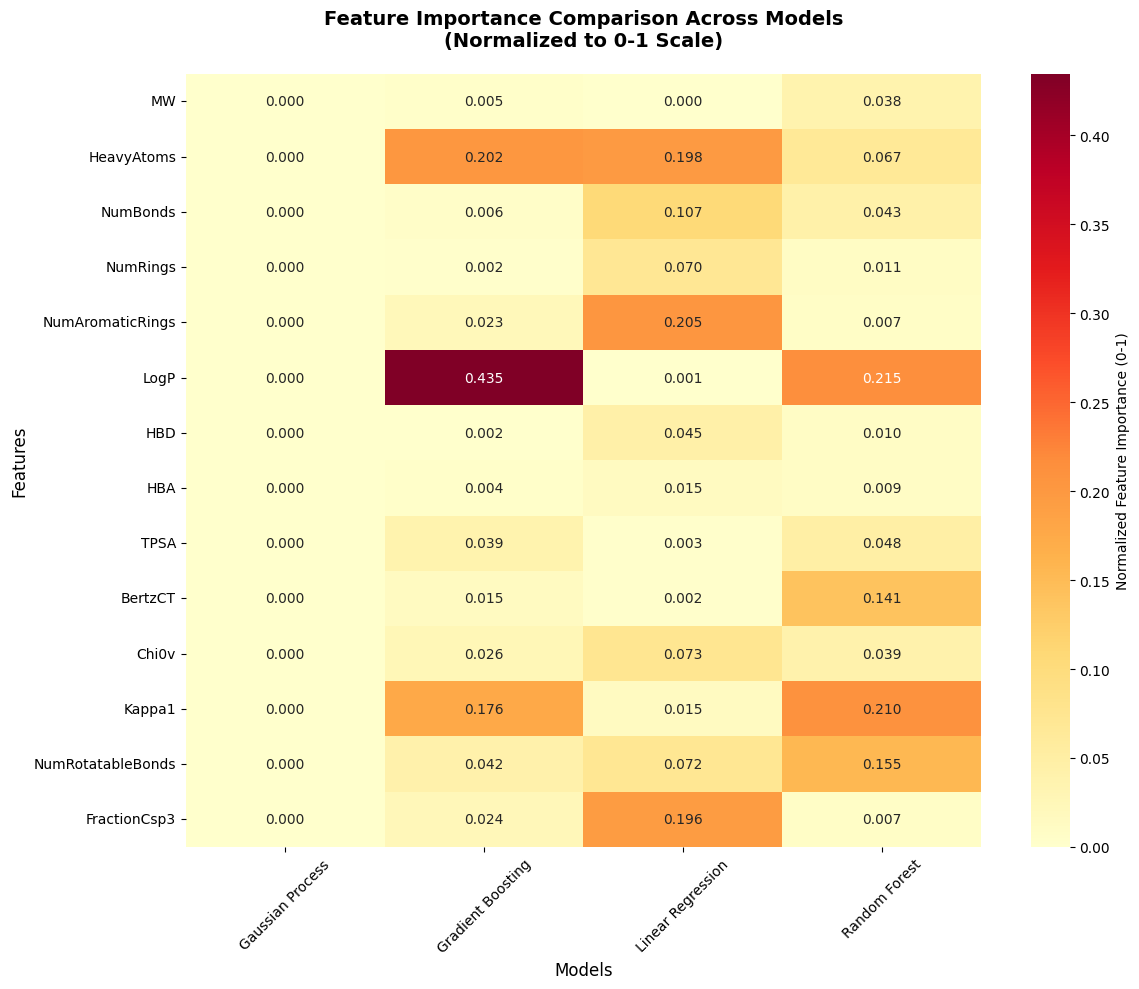


Top 5 Most Important Features by Model:

Gaussian Process:
         feature  importance
              MW         0.0
      HeavyAtoms         0.0
        NumBonds         0.0
        NumRings         0.0
NumAromaticRings         0.0

Gradient Boosting:
          feature  importance
             LogP    0.434661
       HeavyAtoms    0.202428
           Kappa1    0.176032
NumRotatableBonds    0.042239
             TPSA    0.038870

Linear Regression:
         feature  importance
NumAromaticRings    6.006355
      HeavyAtoms    5.810297
    FractionCsp3    5.730894
        NumBonds    3.132046
           Chi0v    2.142077

Random Forest:
          feature  importance
             LogP    0.214740
           Kappa1    0.210282
NumRotatableBonds    0.155116
          BertzCT    0.140883
       HeavyAtoms    0.066695


In [16]:
# 5. Feature importance analysis for all models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance

# Get feature importance for each model
feature_importances = {}

for name, model in models.items():
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_importances[name] = pd.DataFrame({
            'feature': feature_cols,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
    elif hasattr(model, 'coef_'):
        # Linear models
        importances = np.abs(model.coef_)  # Use absolute values
        feature_importances[name] = pd.DataFrame({
            'feature': feature_cols,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
    elif name == 'ANN (MLP)':
        # Permutation importance on scaled data
        perm_importance = permutation_importance(model, X_test_scaled, y_test, 
                                               n_repeats=10, random_state=21, 
                                               scoring='r2')
        importances = perm_importance.importances_mean
        feature_importances[name] = pd.DataFrame({
            'feature': feature_cols,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
    else:
        # Permutation importance on original data
        if name == 'Gaussian Process':
            X_use = X_test
        else:
            X_use = X_test
            
        perm_importance = permutation_importance(model, X_use, y_test, 
                                               n_repeats=10, random_state=21, 
                                               scoring='r2')
        importances = perm_importance.importances_mean
        feature_importances[name] = pd.DataFrame({
            'feature': feature_cols,
            'importance': importances
        }).sort_values('importance', ascending=False)

# Create normalized feature importance matrix for heatmap
all_features = feature_cols
importance_matrix = pd.DataFrame(index=all_features)

for model_name, importance_df in feature_importances.items():
    # Normalize importances to 0-1 scale for each model
    importances = importance_df.set_index('feature')['importance']
    # Handle negative values from permutation importance
    importances = np.maximum(importances, 0)  # Set negative values to 0
    if importances.sum() > 0:
        normalized_importances = importances / importances.sum()  # Normalize to 0-1
    else:
        normalized_importances = importances * 0  # All zeros if sum is 0
    importance_matrix[model_name] = normalized_importances.reindex(all_features, fill_value=0)

# Create heatmap
fig, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(importance_matrix, 
            annot=True, 
            fmt='.3f',
            cmap='YlOrRd',
            cbar_kws={'label': 'Normalized Feature Importance (0-1)'},
            ax=ax)

ax.set_title('Feature Importance Comparison Across Models\n(Normalized to 0-1 Scale)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_ylabel('Features', fontsize=12)
ax.set_xlabel('Models', fontsize=12)
ax.tick_params(axis='y', rotation=0)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print top 5 features for each model
print("\nTop 5 Most Important Features by Model:")
print("=" * 60)
for model_name, importance_df in feature_importances.items():
    print(f"\n{model_name}:")
    print(importance_df.head().to_string(index=False))

#### Plot testing sets

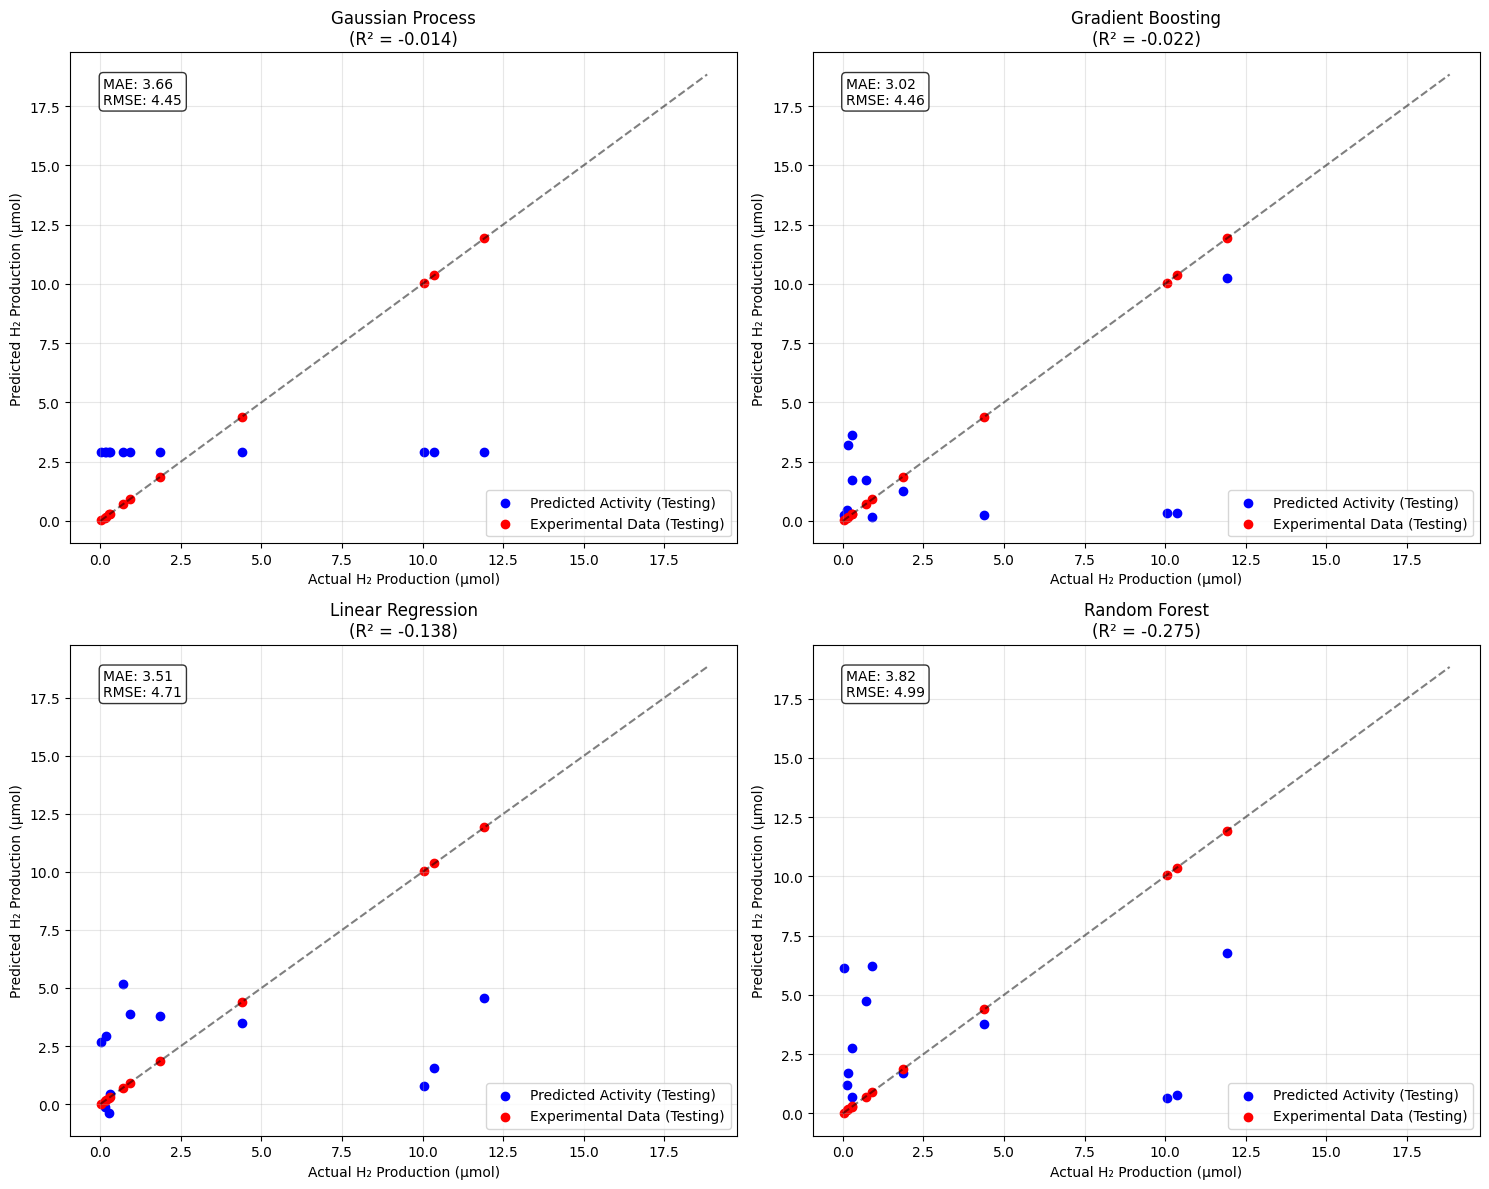


Model Performance Summary:
Gaussian Process     | R²: -0.014 | MAE: 3.66 | RMSE: 4.45
Gradient Boosting    | R²: -0.022 | MAE: 3.02 | RMSE: 4.46
Linear Regression    | R²: -0.138 | MAE: 3.51 | RMSE: 4.71
Random Forest        | R²: -0.275 | MAE: 3.82 | RMSE: 4.99


In [17]:
# 6. Model validation and visualization for all models
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()  # Flatten for easier indexing

for idx, (model_name, model) in enumerate(models.items()):
    # Use appropriate data for each model type
    if model_name == 'ANN (MLP)':
        y_pred = model.predict(X_test_scaled)
        X_full_pred = model.predict(X_scaled)
    else:
        y_pred = model.predict(X_test)
        X_full_pred = model.predict(X)
    
    r2 = r2_score(y_test, y_pred)
    
    # Actual vs Predicted
    axes[idx].scatter(y_test, y_pred, color='blue', label='Predicted Activity (Testing)')
    axes[idx].scatter(y_test, y_test, color='red', label='Experimental Data (Testing)')
    
    axes[idx].set_xlabel('Actual H₂ Production (μmol)')
    axes[idx].set_ylabel('Predicted H₂ Production (μmol)')
    axes[idx].set_title(f'{model_name}\n(R² = {r2:.3f})')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].legend()

    # Perfect prediction line
    min_val = 0
    max_val = max(y.max(), X_full_pred.max())
    axes[idx].plot([min_val, max_val], [min_val, max_val], 
                   'k--', alpha=0.5, label='Perfect Prediction')
    
    # Add text with additional metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    axes[idx].text(0.05, 0.95, f'MAE: {mae:.2f}\nRMSE: {rmse:.2f}', 
                   transform=axes[idx].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print summary comparison
print("\nModel Performance Summary:")
print("=" * 50)
for model_name in models.keys():
    if model_name == 'ANN (MLP)':
        y_pred = models[model_name].predict(X_test_scaled)
    else:
        y_pred = models[model_name].predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"{model_name:20} | R²: {r2:.3f} | MAE: {mae:.2f} | RMSE: {rmse:.2f}")